{'PoolQC': 1453, 'LotFrontage': 259, 'GarageQual': 81, 'MiscFeature': 1406, 'BsmtQual': 37, 'Fence': 1179, 'BsmtCond': 37, 'MasVnrType': 8, 'Alley': 1369, 'BsmtFinType1': 37, 'GarageCond': 81, 'Electrical': 1, 'GarageType': 81, 'BsmtFinType2': 38, 'MasVnrArea': 8, 'FireplaceQu': 690, 'GarageYrBlt': 81, 'GarageFinish': 81, 'BsmtExposure': 38}


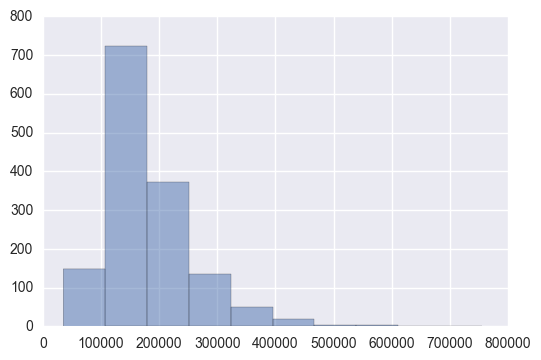

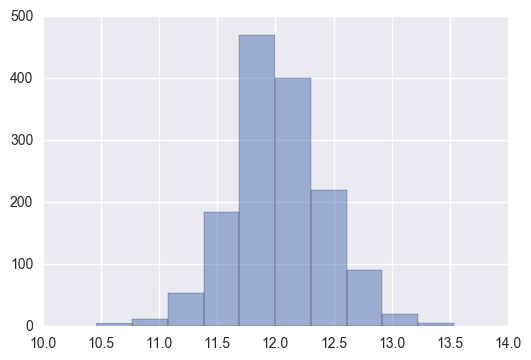

In [91]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
from __future__ import division
import sklearn.linear_model as linear_model

#Loading the training and the test data
Train_df = pd.read_csv('C:/Users/Mash/Desktop/Kaggle/Regression_house_prices/train.csv')
Test_df = pd.read_csv('C:/Users/Mash/Desktop/Kaggle/Regression_house_prices/test.csv')

#print (Train_df.columns)
#print (Train_df.describe())

# No of columns in the df
#print (Train_df.info())

#Segregating Quantitative and Qualitative columns
quantitative = [f for f in Train_df.columns if Train_df.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in Train_df.columns if Train_df.dtypes[f] == 'object']

# checking the columns with NaN values
NaN_columns = {}
for i in Train_df.columns:
    if pd.isnull(Train_df[i]).sum() >0:
        NaN_columns[i] = pd.isnull(Train_df[i]).sum()
print (NaN_columns)

#Analysing the sale price normality and applying log transformation since the original values are right skewed
plt.hist(Train_df['SalePrice'], alpha = 0.5)
plt.show()
y =np.log(Train_df['SalePrice'])
plt.hist(y,alpha = 0.5)
plt.show()



C:\Users\Mash\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


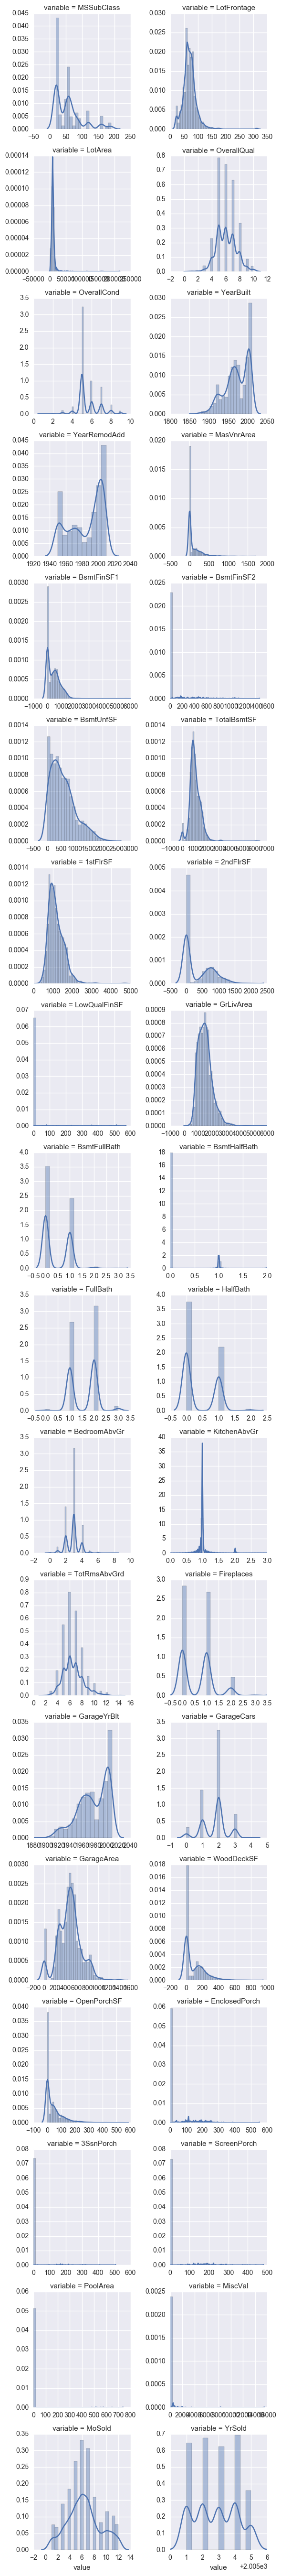

In [59]:
# Checking the distribution of all quantitative varibles
f = pd.melt(Train_df, value_vars=quantitative)
graph  = sns.FacetGrid(f,col = "variable",col_wrap=2,sharex=False, sharey=False)
graph = graph.map(sns.distplot, "value")

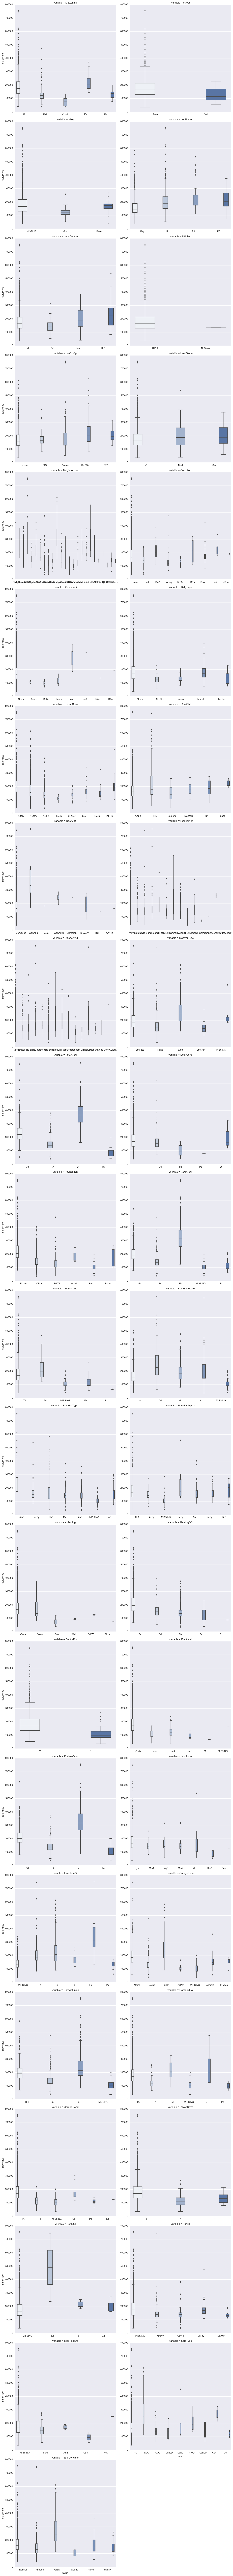

In [92]:
# Checking the Quanlitative variable and adding a category MISSING if Nan is present

for i in qualitative:
    if Train_df[i].isnull().any():
        Train_df[i]=Train_df[i].fillna('MISSING')

#Using box plots to plot categorical data along with sale price
f = pd.melt(Train_df ,value_vars = qualitative, id_vars='SalePrice')
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=7)
g = g.map(sns.boxplot,'value','SalePrice',"value")


(43, 2)
(43, 2)


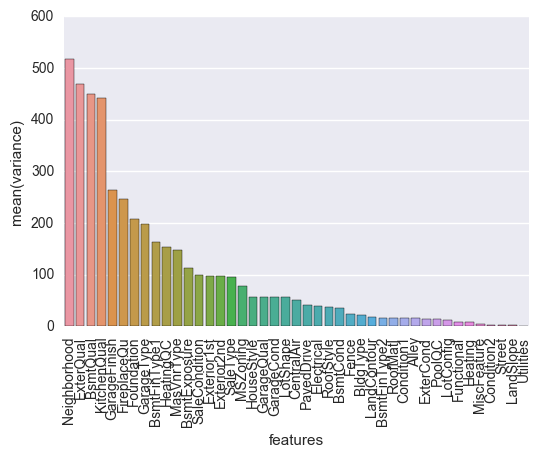

In [93]:
#Grouping the categorical variables to check the ANOVA
#If the P value is less among them ,then they have low impact on the sale price else high impact

def anova(train):
    anova_df = pd.DataFrame({'features':qualitative})
    pvals = []
    for i in qualitative:
        values =[]
        for j in train[i].unique():
            SP = train[train[i]==j]['SalePrice'].values
            values.append(SP)
        #print (*values)
        pval = stats.f_oneway(*values)[1]
        pvals.append(pval)
    anova_df['pvals'] = pvals
    return anova_df.sort_values('pvals')        
a = anova(Train_df)
print (a.shape)
a = a[a.pvals.notnull()]
print (a.shape)
a['variance'] = np.log(1/a['pvals'].values)
sns.barplot(data = a, x = 'features', y = 'variance')
x=plt.xticks(rotation=90) #[ for making the features visible]

In [94]:
# from the above only the variables with non null P value to be considered for further operations
qualitative_reduced =a.features
print (qualitative_reduced)

8      Neighborhood
18        ExterQual
21         BsmtQual
30      KitchenQual
34     GarageFinish
32      FireplaceQu
20       Foundation
33       GarageType
24     BsmtFinType1
27        HeatingQC
17       MasVnrType
23     BsmtExposure
42    SaleCondition
15      Exterior1st
16      Exterior2nd
41         SaleType
0          MSZoning
12       HouseStyle
35       GarageQual
36       GarageCond
3          LotShape
28       CentralAir
37       PavedDrive
29       Electrical
13        RoofStyle
22         BsmtCond
39            Fence
11         BldgType
4       LandContour
25     BsmtFinType2
14         RoofMatl
9        Condition1
2             Alley
19        ExterCond
38           PoolQC
6         LotConfig
31       Functional
26          Heating
40      MiscFeature
10       Condition2
1            Street
7         LandSlope
5         Utilities
Name: features, dtype: object


In [95]:
#categorical variable encoding (target  based for regression)
# http://www.saedsayad.com/encoding.htm - refer example 2
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    #print (ordering.spmean)
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o

qual_encoded = []
for q in qualitative_reduced:  
    encode(Train_df, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)


['Neighborhood_E', 'ExterQual_E', 'BsmtQual_E', 'KitchenQual_E', 'GarageFinish_E', 'FireplaceQu_E', 'Foundation_E', 'GarageType_E', 'BsmtFinType1_E', 'HeatingQC_E', 'MasVnrType_E', 'BsmtExposure_E', 'SaleCondition_E', 'Exterior1st_E', 'Exterior2nd_E', 'SaleType_E', 'MSZoning_E', 'HouseStyle_E', 'GarageQual_E', 'GarageCond_E', 'LotShape_E', 'CentralAir_E', 'PavedDrive_E', 'Electrical_E', 'RoofStyle_E', 'BsmtCond_E', 'Fence_E', 'BldgType_E', 'LandContour_E', 'BsmtFinType2_E', 'RoofMatl_E', 'Condition1_E', 'Alley_E', 'ExterCond_E', 'PoolQC_E', 'LotConfig_E', 'Functional_E', 'Heating_E', 'MiscFeature_E', 'Condition2_E', 'Street_E', 'LandSlope_E', 'Utilities_E']


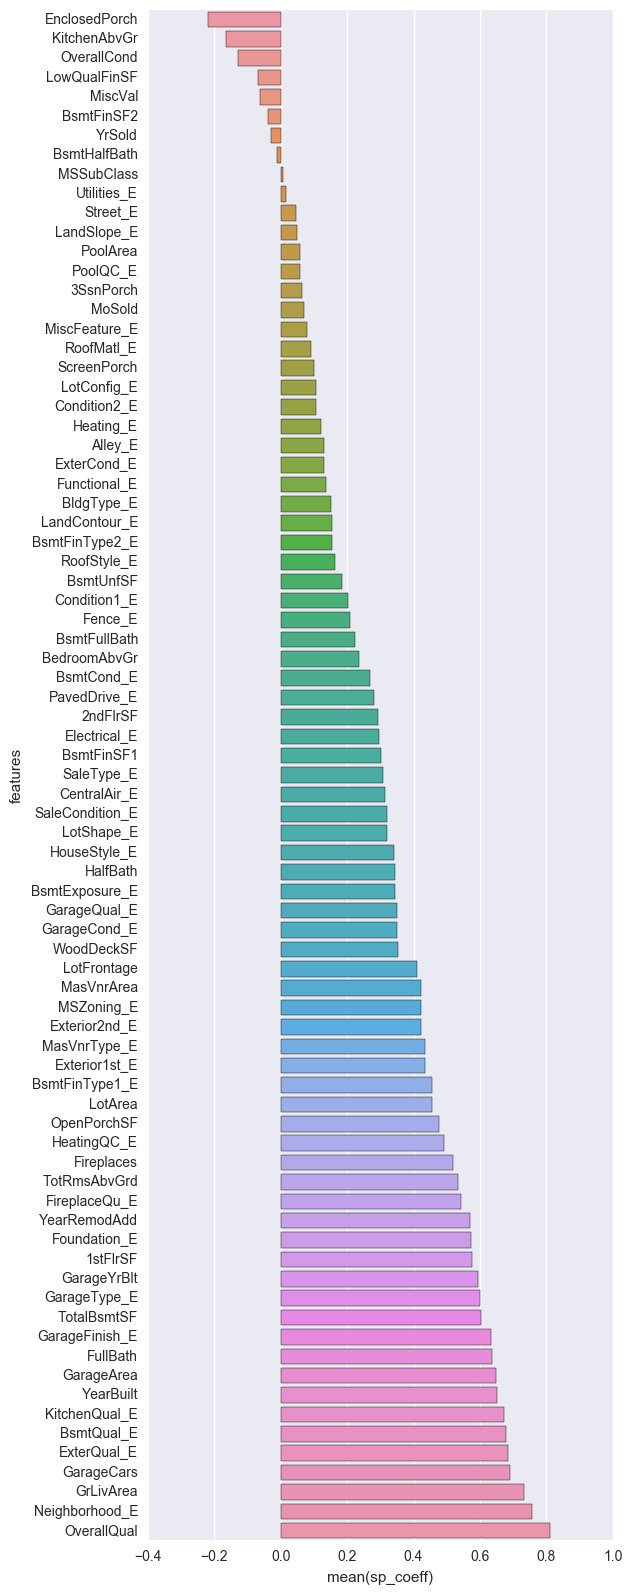

In [96]:
#Checking the Corelation of variables using spearmans coefficient
combo_features = quantitative + qual_encoded
spr = pd.DataFrame({'features':combo_features})
spr['sp_coeff'] = [Train_df[f].corr(Train_df['SalePrice'],'spearman') for f in combo_features]
spr = spr.sort_values('sp_coeff')
plt.figure(figsize=(6, 0.25*len(combo_features)))
sns.barplot(data=spr, y='features', x='sp_coeff', orient='h')

In [97]:
# choosing features which have a co-relation over 0.2
filtered_features = spr[spr.sp_coeff>0.2].features
# number of significant features = 37
f_quant = []
f_qual = []
for i in filtered_features:
    if i in quantitative:
        f_quant.append(i)
    else:
        f_qual.append(i)
print (f_quant)
print (f_qual)

['BsmtFullBath', 'BedroomAbvGr', '2ndFlrSF', 'BsmtFinSF1', 'HalfBath', 'WoodDeckSF', 'LotFrontage', 'MasVnrArea', 'LotArea', 'OpenPorchSF', 'Fireplaces', 'TotRmsAbvGrd', 'YearRemodAdd', '1stFlrSF', 'GarageYrBlt', 'TotalBsmtSF', 'FullBath', 'GarageArea', 'YearBuilt', 'GarageCars', 'GrLivArea', 'OverallQual']
['Condition1_E', 'Fence_E', 'BsmtCond_E', 'PavedDrive_E', 'Electrical_E', 'SaleType_E', 'CentralAir_E', 'SaleCondition_E', 'LotShape_E', 'HouseStyle_E', 'BsmtExposure_E', 'GarageQual_E', 'GarageCond_E', 'MSZoning_E', 'Exterior2nd_E', 'MasVnrType_E', 'Exterior1st_E', 'BsmtFinType1_E', 'HeatingQC_E', 'FireplaceQu_E', 'Foundation_E', 'GarageType_E', 'GarageFinish_E', 'KitchenQual_E', 'BsmtQual_E', 'ExterQual_E', 'Neighborhood_E']


In [98]:
# for right skewed features
def log_transform(df,feature):
    df[feature] = np.log1p(df[feature].values)

# for left skewed features
def quadratic(df,feature):
    df[feature] = df[feature]**2

#for error calculation
def RMSD(actual,predicted):
    actual =np.log(actual)
    predicted = np.log(predicted)
    RMSD = np.sqrt(np.sum((actual-predicted)**2)/len(actual))
    return RMSD
    
log_transform(Train_df,'GrLivArea')
log_transform(Train_df,'1stFlrSF')
log_transform(Train_df,'2ndFlrSF')
log_transform(Train_df,'TotalBsmtSF')
log_transform(Train_df,'LotArea')
log_transform(Train_df,'LotFrontage')
log_transform(Train_df,'GarageArea')

quadratic(Train_df,'OverallQual')
quadratic(Train_df,'YearBuilt')
quadratic(Train_df,'YearRemodAdd')
quadratic(Train_df,'TotalBsmtSF')
quadratic(Train_df,'2ndFlrSF')
quadratic(Train_df,'GrLivArea')

final_features = filtered_features
lasso = linear_model.LassoLarsCV(max_iter=10000)
X = Train_df[final_features].fillna(0.).values
Y = Train_df['SalePrice'].values
lasso.fit(X, np.log(Y))

Ypred = np.exp(lasso.predict(X))
print (RMSD(Y, Ypred))


0.130860102401


C:\Users\Mash\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 59 iterations, alpha=2.230e-05, previous alpha=1.952e-06, with an active set of 48 regressors.
  ConvergenceWarning)


In [99]:
# Working on the Test Set

def encode_Test(Test,feature,Train):
    ordering = pd.DataFrame()
    ordering['val'] = Train[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = Train[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    #print (ordering.spmean)
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    for cat, o in ordering.items():
        Test.loc[Test[feature] == cat, feature+'_E'] = o
    
for i in qualitative:
    if Test_df[i].isnull().any():
        Test_df[i]=Test_df[i].fillna('MISSING')

for q in qualitative_reduced:  
    encode_Test(Test_df,q,Train_df)


In [100]:
# Transforming the test set and writing the output file

import csv

log_transform(Test_df,'GrLivArea')
log_transform(Test_df,'1stFlrSF')
log_transform(Test_df,'2ndFlrSF')
log_transform(Test_df,'TotalBsmtSF')
log_transform(Test_df,'LotArea')
log_transform(Test_df,'LotFrontage')
log_transform(Test_df,'GarageArea')

quadratic(Test_df,'OverallQual')
quadratic(Test_df,'YearBuilt')
quadratic(Test_df,'YearRemodAdd')
quadratic(Test_df,'TotalBsmtSF')
quadratic(Test_df,'2ndFlrSF')
quadratic(Test_df,'GrLivArea')

#print (final_features)
X_test = Test_df[final_features].fillna(0.).values
Y_test = np.exp(lasso.predict(X_test))
print (Y_test)
predictions_file = open("C:/Users/Mash/Desktop/Kaggle/Regression_house_prices/Lasso_output.csv", "w",newline='')
predictions_file_object = csv.writer(predictions_file)
predictions_file_object.writerow(["Id", "SalePrice"])
for i in range(len(Test_df)):
    predictions_file_object.writerow([Test_df['Id'][i],Y_test[i]])
predictions_file.close()

[ 111921.51498259  156459.65681301  176898.83950997 ...,  158804.9814196
  117577.34084086  217918.6983234 ]
